In [17]:
import easyocr
import re

reader = easyocr.Reader(['en'])
results = reader.readtext('credit-card2.png')

card_number = None
expiry_date = None
cardholder_name = None

for _, text, _ in results:
    clean_text = text.strip()

    # Card Number
    if re.fullmatch(r'(\d{4}[\s\-]?){4}', clean_text.replace(' ', '').replace('-', '')):
        card_number = clean_text

    # Expiry Date
    elif re.fullmatch(r'(0[1-9]|1[0-2])\/?([0-9]{2,4})', clean_text):
        expiry_date = clean_text

    # Cardholder Name (Uppercase and not numbers)
    elif clean_text.isupper() and not any(char.isdigit() for char in clean_text) and len(clean_text.split()) >= 2:
        cardholder_name = clean_text

print("Card Number:", card_number)
print("Expiry Date:", expiry_date)
print("Cardholder Name:", cardholder_name)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Card Number: 2221 0012 3412 3456
Expiry Date: 12/23
Cardholder Name: VALID TARU


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


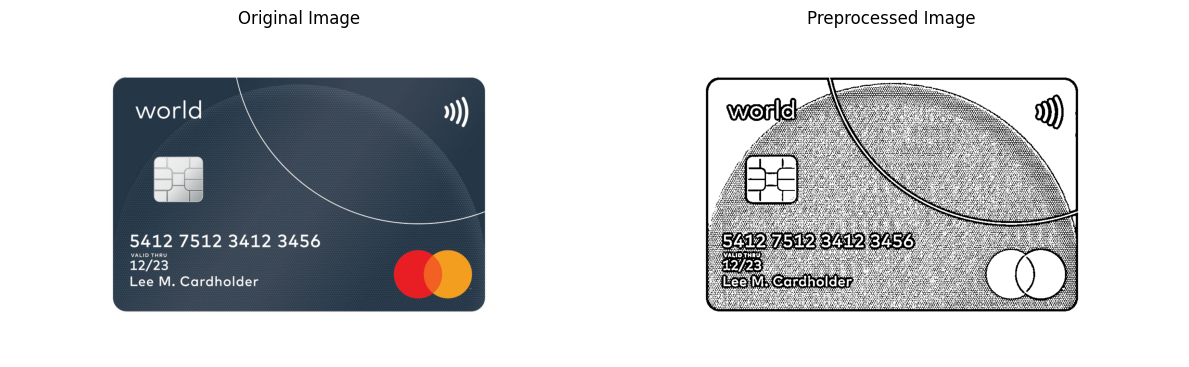

world (Confidence: 1.00)
5412 7512 3412 3456 (Confidence: 0.81)
VALID THRU (Confidence: 0.66)
12/23 (Confidence: 1.00)
Lee M. Cardholder (Confidence: 0.83)

Extracted Credit Card Information:
---------------------------------
Card Number: 5412751234123456
Expiry Date: 12/23
Cardholder Name: Lee M. Cardholder
Card Network: MasterCard


In [2]:
import cv2
import numpy as np
import re
import matplotlib.pyplot as plt
from PIL import Image
import easyocr
import os

class CreditCardReader:
    def __init__(self):
        # Initialize the EasyOCR reader
        self.reader = easyocr.Reader(['en'])
        
        # Regular expressions for card information
        self.card_number_pattern = r'\d{4}\s*\d{4}\s*\d{4}\s*\d{4}'
        self.expiry_date_pattern = r'\d{2}/\d{2}'
        
    def preprocess_image(self, image_path):
        """Preprocess the image for better OCR results"""
        # Read the image
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Could not open or find the image: {image_path}")
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 11, 2
        )
        
        # Invert the image if needed (dark text on light background)
        # Detect if we have light text on dark background
        if np.mean(gray) < 127:
            thresh = cv2.bitwise_not(thresh)
            
        return img, thresh, gray
    
    def extract_text(self, img):
        """Extract all text from the image using EasyOCR"""
        results = self.reader.readtext(img)
        return results
    
    def extract_card_info(self, image_path):
        """Main function to extract credit card information"""
        # Preprocess the image
        original, preprocessed, gray = self.preprocess_image(image_path)
        
        # Extract text using EasyOCR
        results = self.extract_text(gray)
        
        # Display the image and extracted text
        plt.figure(figsize=(12, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(preprocessed, cmap='gray')
        plt.title("Preprocessed Image")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Convert OCR results to text
        full_text = ""
        ocr_text_with_positions = []
        
        for (bbox, text, prob) in results:
            full_text += text + " "
            ocr_text_with_positions.append((text, bbox, prob))
            print(f"{text} (Confidence: {prob:.2f})")
        
        # Parse credit card number
        card_number = self.extract_card_number(results)
        
        # Parse expiry date
        expiry_date = self.extract_expiry_date(results)
        
        # Parse cardholder name
        cardholder_name = self.extract_cardholder_name(results)
        
        return {
            "card_number": card_number,
            "expiry_date": expiry_date,
            "cardholder_name": cardholder_name,
            "raw_text": full_text,
            "detailed_results": ocr_text_with_positions
        }
    
    def extract_card_number(self, ocr_results):
        """Extract the credit card number from OCR results"""
        # Look for 16-digit numbers
        for (bbox, text, prob) in ocr_results:
            # Clean text of spaces and non-digits
            cleaned_text = re.sub(r'\D', '', text)
            
            # Check for standard card number pattern
            match = re.search(self.card_number_pattern, text)
            if match:
                return re.sub(r'\D', '', match.group(0))
                
            # Check for any 16-digit sequence
            if len(cleaned_text) >= 16:
                return cleaned_text[:16]
                
            # Check if this text contains 4 consecutive digits (part of a card number)
            if re.match(r'\d{4}', cleaned_text) and len(cleaned_text) == 4:
                # This might be part of a card number, look for neighboring text boxes
                potential_parts = []
                for (_, other_text, _) in ocr_results:
                    if re.match(r'\d{4}', re.sub(r'\D', '', other_text)) and len(re.sub(r'\D', '', other_text)) == 4:
                        potential_parts.append(re.sub(r'\D', '', other_text))
                
                if len(potential_parts) >= 4:
                    return ''.join(potential_parts[:4])
        
        # If we couldn't find a card number using standard methods,
        # Try combining all digit sequences in the image
        all_digits = ''
        for (_, text, _) in ocr_results:
            digits = re.sub(r'\D', '', text)
            all_digits += digits
            
        if len(all_digits) >= 16:
            return all_digits[:16]
            
        return "Not Found"
    
    def extract_expiry_date(self, ocr_results):
        """Extract the expiry date from OCR results"""
        for (bbox, text, prob) in ocr_results:
            # Look for the MM/YY pattern
            match = re.search(self.expiry_date_pattern, text)
            if match:
                return match.group(0)
                
            # Look for text containing "valid thru" or similar
            if re.search(r'valid|thru|exp|expires|expiry', text.lower()):
                # Look for nearby digit patterns
                for (_, nearby_text, _) in ocr_results:
                    date_match = re.search(self.expiry_date_pattern, nearby_text)
                    if date_match:
                        return date_match.group(0)
                        
                    # Look for two pairs of digits that could be MM/YY
                    digits = re.findall(r'\d{2}', nearby_text)
                    if len(digits) >= 2:
                        # Check if first pair could be a month (01-12)
                        if 1 <= int(digits[0]) <= 12:
                            return f"{digits[0]}/{digits[1]}"
        
        # If we still couldn't find a date, look for any pair of numbers that could be a date
        for (_, text, _) in ocr_results:
            digits = re.findall(r'\d{2}', text)
            if len(digits) >= 2:
                # Check if first pair could be a month (01-12)
                if 1 <= int(digits[0]) <= 12:
                    return f"{digits[0]}/{digits[1]}"
        
        return "Not Found"
    
    def extract_cardholder_name(self, ocr_results):
        """Extract the cardholder name from OCR results"""
        # Names on credit cards are usually in all caps
        # and are often on their own line
        potential_names = []
        
        for (bbox, text, prob) in ocr_results:
            # Skip text that looks like card numbers or dates
            if re.search(r'\d{4}', text) or re.search(self.expiry_date_pattern, text):
                continue
                
            # Look for text in ALL CAPS that could be a name
            if text.isupper() and len(text.split()) >= 2:
                # Check that it doesn't contain common card labels
                if not re.search(r'VALID|THRU|EXP|MEMBER|SINCE|CREDIT|CARD|DEBIT|GOLD', text):
                    potential_names.append((text, prob))
            
            # Look for text that matches common name patterns
            name_match = re.search(r'([A-Z][a-z]+\s+([A-Z]\.?\s+)?[A-Z][a-z]+)', text)
            if name_match:
                potential_names.append((name_match.group(0), prob))
                
            # Look for all caps name pattern with initials
            name_match = re.search(r'([A-Z]+\s+[A-Z]\.?\s+[A-Z]+)', text)
            if name_match:
                potential_names.append((name_match.group(0), prob))
        
        # Sort by confidence and return the best match
        if potential_names:
            potential_names.sort(key=lambda x: x[1], reverse=True)
            return potential_names[0][0]
            
        return "Not Found"
    
    def detect_card_network(self, card_number):
        """Detect the card network based on the card number"""
        if not card_number or card_number == "Not Found":
            return "Unknown"
            
        # Remove spaces and non-digit characters
        cleaned_number = re.sub(r'\D', '', card_number)
        
        # Check first digits to determine card network
        if cleaned_number.startswith('4'):
            return "Visa"
        elif cleaned_number.startswith(('51', '52', '53', '54', '55')) or cleaned_number.startswith(('2221', '2222', '2223', '2224', '2225', '2226', '2227', '2228', '2229', '223', '224', '225', '226', '227', '228', '229', '23', '24', '25', '26', '270', '271', '2720')):
            return "MasterCard"
        elif cleaned_number.startswith(('34', '37')):
            return "American Express"
        elif cleaned_number.startswith(('300', '301', '302', '303', '304', '305', '36', '38')):
            return "Diners Club"
        elif cleaned_number.startswith('6'):
            return "Discover"
        elif cleaned_number.startswith(('62', '81')):
            return "UnionPay"
        else:
            return "Unknown"


def main():
    # Initialize the credit card reader
    reader = CreditCardReader()
    
    # Process a credit card image
    image_path = 'credit-card1.jpg'  # Replace with your image path
    
    try:
        # Extract card information
        card_info = reader.extract_card_info(image_path)
        
        # Detect the card network
        card_network = reader.detect_card_network(card_info["card_number"])
        
        # Print the results
        print("\nExtracted Credit Card Information:")
        print("---------------------------------")
        print(f"Card Number: {card_info['card_number']}")
        print(f"Expiry Date: {card_info['expiry_date']}")
        print(f"Cardholder Name: {card_info['cardholder_name']}")
        print(f"Card Network: {card_network}")
        
        # Visualize the results on the image
        # You could add code here to draw bounding boxes around detected information
        
    except Exception as e:
        print(f"Error processing image: {str(e)}")


if __name__ == "__main__":
    main()